이번 중간고사에 사용된 모든 소스코드는 제 깃허브에 올려두었습니다. https://github.com/supergermy/midexam

## Discussion

* ### 프로젝트 개요
본 중간고사 과제는 주어진 데이터셋을 활용하여 분류(Classification)와 회귀(Regression) 모델을 구현하는 것이었습니다.

* ### 연구 목적
본 연구의 주요 목적은 수업에서 학습한 다양한 분자 표현자(Molecular Descriptors) 중에서 특정 물성 예측에 가장 효과적인 표현자를 딥러닝 모델이 자동으로 학습하고 식별하는 것입니다.

* ### 사용된 분자 표현자
분석에 활용된 네 가지 주요 분자 표현 방식:
    1. RDKit Molecular Descriptors *(기존 tree based model 과제 결과를 토대로 top 20 features만 사용)*
    2. Morgan Fingerprint (radius=2, 2048)
    3. ChemBERT2a Embedding
    4. Molformer Embedding

* ### 딥러닝 모델 구조
최종 모델은 다음과 같은 구조로 설계되었습니다:
    - 과적합을 막기위해 네 개의 독립적인 아주 간단한 FeedForward모델이 각각의 분자 표현자를 처리 *(input layer -> fc1 -> fc2 -> output layer * λ_n)*
    - 학습 가능한 가중치 파라미터(λ_1~λ_4)를 도입하여 각 표현자의 중요도를 자동으로 학습
    - 가중치가 적용된 특징들을 결합하여 최종 예측값 도출

이러한 접근 방식을 통해 각 분자 표현자의 상대적 중요도를 정량적으로 평가할 수 있습니다.

## Result

* ### MSELoss
    모델은 Epoch 245에서 가장 낮은 validation loss를 보였습니다. 이때 모델의 performances 는 다음과 같습니다.
    * val MSELoss: 0.262
    * val PearsonCorrCoef: 0.721
    * val SpearmanCorrCoef: 0.740

* ### Learnt Lambdas
    모델은 학습 가능한 파라미터 λ를 최적화 시켰기 때문에, 그 값들을 비교하면 features 중요도로 나눌 수 있습니다.
    * λ_1. RDKit Molecular Descriptors: 0.244
    * λ_2. Morgan Fingerprint: 0.247
    * λ_3. ChemBERT2a Embedding: 0.256
    * λ_4. Molformer Embedding: 0.253

(중요도 순서) ChemBERT2a > Molformer > Morgan > RDKit

**위와 같은 중요도의 정도는 classification과 regression에서 비슷하다는 점에서 신뢰할만 하다고 볼 수 있습니다.**

## Interpreting the results

* 본 연구를 통해 적은 규모의 데이터셋에도 불구하고 과적합을 효과적으로 제어하는 딥러닝 모델을 성공적으로 구현했습니다.

* 특히 주목할 만한 점은 전통적인 수작업 특징(Hand-crafted Features)보다 딥러닝 기반의 분자 표현 방식, 특히 Chemical Language Model이 학습한 임베딩이 모델 성능 향상에 크게 기여했다는 것입니다.

    이러한 결과는 다음을 시사합니다:
    * 사전 학습된 언어 모델의 효과적인 지식 전이
    * 분자 구조의 복잡한 패턴을 자동으로 포착하는 딥러닝의 강점
    * 전통적인 분자 특징 추출 방식의 한계

### 0. install and import dependencies and get target datasets

In [ ]:
!pip uninstall midexam --y
!pip install git+https://github.com/supergermy/midexam.git

Found existing installation: midexam 0.1
Uninstalling midexam-0.1:
  Successfully uninstalled midexam-0.1
  Cloning https://github.com/supergermy/midexam.git to /tmp/pip-req-build-xklz6c2r
  Running command git clone --filter=blob:none --quiet https://github.com/supergermy/midexam.git /tmp/pip-req-build-xklz6c2r
  Resolved https://github.com/supergermy/midexam.git to commit 7d1d6e04fc3e02b1d226547cf69cb2a23671b16b
  Preparing metadata (setup.py) ... done
  Created wheel for midexam: filename=midexam-0.1-py3-none-any.whl size=10114 sha256=226a6719df80240a8fbc711b5827076df9a5790fd48cdc02f8a9f29ee8e66e9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-q4mzjh4d/wheels/d3/85/ee/16ac6f04e59a2ca34a436814241badd7a1cf00dad11f6d6591
Successfully built midexam


In [ ]:
!wget https://raw.githubusercontent.com/supergermy/midexam/refs/heads/main/midexam/datasets/B3DB_regression.tsv
!wget https://raw.githubusercontent.com/supergermy/midexam/refs/heads/main/midexam/datasets/B3DB_classification.tsv

--2024-10-26 06:51:15--  https://raw.githubusercontent.com/supergermy/midexam/refs/heads/main/midexam/datasets/B3DB_regression.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378224 (369K) [text/plain]
Saving to: ‘B3DB_regression.tsv.1’

B3DB_regression.tsv 100%[===================>] 369.36K   860KB/s    in 0.4s    

2024-10-26 06:51:16 (860 KB/s) - ‘B3DB_regression.tsv.1’ saved [378224/378224]

--2024-10-26 06:51:16--  https://raw.githubusercontent.com/supergermy/midexam/refs/heads/main/midexam/datasets/B3DB_classification.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP 

In [ ]:
import torch
from torch import optim
import torch.nn.functional as F
from torchmetrics import AUROC, Precision, Recall, PearsonCorrCoef, SpearmanCorrCoef

from midexam import PropertyRegressors

from midexam import get_fingerprints
from midexam import get_molecular_descriptors
from midexam import get_chembert2as
from midexam import get_molformers
from midexam import create_data_loaders

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchmetrics import AUROC
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'device is {device}')

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device is cuda


# **1. get features and embeddings**

In [ ]:
task = 'regression'

descriptors = get_molecular_descriptors(task).to(device)
print(f"descriptor tensor shape: {descriptors.shape}")  # [num_samples, 20]

fingerprints, label_tensor = get_fingerprints(task)
print(f"fingerprint tensor shape: {fingerprints.shape}")  # [num_samples, 2048]

chembert2as = get_chembert2as(task).to(device)
print(f"chembert2a tensor shape: {chembert2as.shape}")  # [num_samples, 600]

molformers = get_molformers(task).to(device)
print(f"molformers tensor shape: {molformers.shape}")  # [num_samples, 768]

get_molecular_descriptors: 100%|██████████| 1058/1058 [00:12<00:00, 82.29it/s]


descriptor tensor shape: torch.Size([1058, 20])


get_fingerprints: 100%|██████████| 1058/1058 [00:00<00:00, 3346.83it/s]


fingerprint tensor shape: torch.Size([1058, 2048])


get_chembert2as: 100%|██████████| 1058/1058 [00:06<00:00, 153.50it/s]


chembert2a tensor shape: torch.Size([1058, 600])


get_molformers: 100%|██████████| 1058/1058 [00:36<00:00, 29.33it/s]

molformers tensor shape: torch.Size([1058, 768])


# **2. set train and val loaders**

In [ ]:
train_loader, val_loader = create_data_loaders(
    descriptors=descriptors,
    fingerprints=fingerprints,
    chembert2as=chembert2as,
    molformers=molformers,
    labels=label_tensor,
    batch_size=256
)

num_epochs = 300

# **3. set and train the model**

In [ ]:
# Initialize model, optimizer, and loss function
model = PropertyRegressors(128, 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6, last_epoch=-1)
criterion = torch.nn.BCEWithLogitsLoss() if task == 'classification' else torch.nn.MSELoss()

# Training loop
epoch_loss = 0.0
epoch_val_loss = 0.0

metrics = {
    'classification': [AUROC('binary').to(device), Precision('binary').to(device), Recall('binary').to(device)],
    'regression': [PearsonCorrCoef().to(device), SpearmanCorrCoef().to(device)]
}

train_losses = []
val_losses = []

train_metrics = {metric.__class__.__name__: [] for metric in metrics[task]}
val_metrics = {metric.__class__.__name__: [] for metric in metrics[task]}

train_lambdas = []

epoch_val_predictions = []
epoch_val_labels = []

for _ in tqdm(range(num_epochs), 'Epoch'):
    # Training phase
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        desc = batch['descriptors']
        fps = batch['fingerprints']
        chembert = batch['chembert2as']
        molformer = batch['molformers']
        labels = batch['label']

        # desc = torch.zeros_like(desc)
        # fps = torch.zeros_like(fps)
        # chembert = torch.zeros_like(chembert)
        # molformer = torch.zeros_like(molformer)

        predictions, lambdas = model(desc, fps, chembert, molformer)
        loss = criterion(predictions, labels)

        for metric in metrics[task]:
            metric.update(predictions, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # End of training epoch
    scheduler.step()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Record training metrics
    for metric in metrics[task]:
        metric_value = metric.compute()
        train_metrics[metric.__class__.__name__].append(metric_value.detach().cpu())
        metric.reset()

    train_lambdas.append(lambdas.detach().cpu())
    epoch_loss = 0.0

    # Validation phase
    model.eval()
    with torch.no_grad():
        batch_val_predictions = []
        batch_val_labels = []

        for batch in val_loader:
            desc = batch['descriptors']
            fps = batch['fingerprints']
            chembert = batch['chembert2as']
            molformer = batch['molformers']
            val_labels = batch['label']

            # desc = torch.zeros_like(desc)
            # fps = torch.zeros_like(fps)
            # chembert = torch.zeros_like(chembert)
            # molformer = torch.zeros_like(molformer)

            val_predictions, val_lambdas = model(desc, fps, chembert, molformer)
            loss = criterion(val_predictions, val_labels)

            for metric in metrics[task]:
                metric.update(val_predictions, val_labels)

            epoch_val_loss += loss.item()
            batch_val_predictions.extend(val_predictions.sigmoid().detach().cpu() if task == 'classification' else val_predictions.detach().cpu())
            batch_val_labels.extend(val_labels.detach().cpu())

        # Record validation metrics
        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)

        for metric in metrics[task]:
            metric_value = metric.compute()
            val_metrics[metric.__class__.__name__].append(metric_value.detach().cpu())
            metric.reset()

        epoch_val_predictions.append(batch_val_predictions)
        epoch_val_labels.append(batch_val_labels)
        epoch_val_loss = 0.0

print(lambdas)

Epoch: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]

tensor([[0.2429],
        [0.2471],
        [0.2563],
        [0.2536]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


# **4. visualize the learning process and check the best performance**

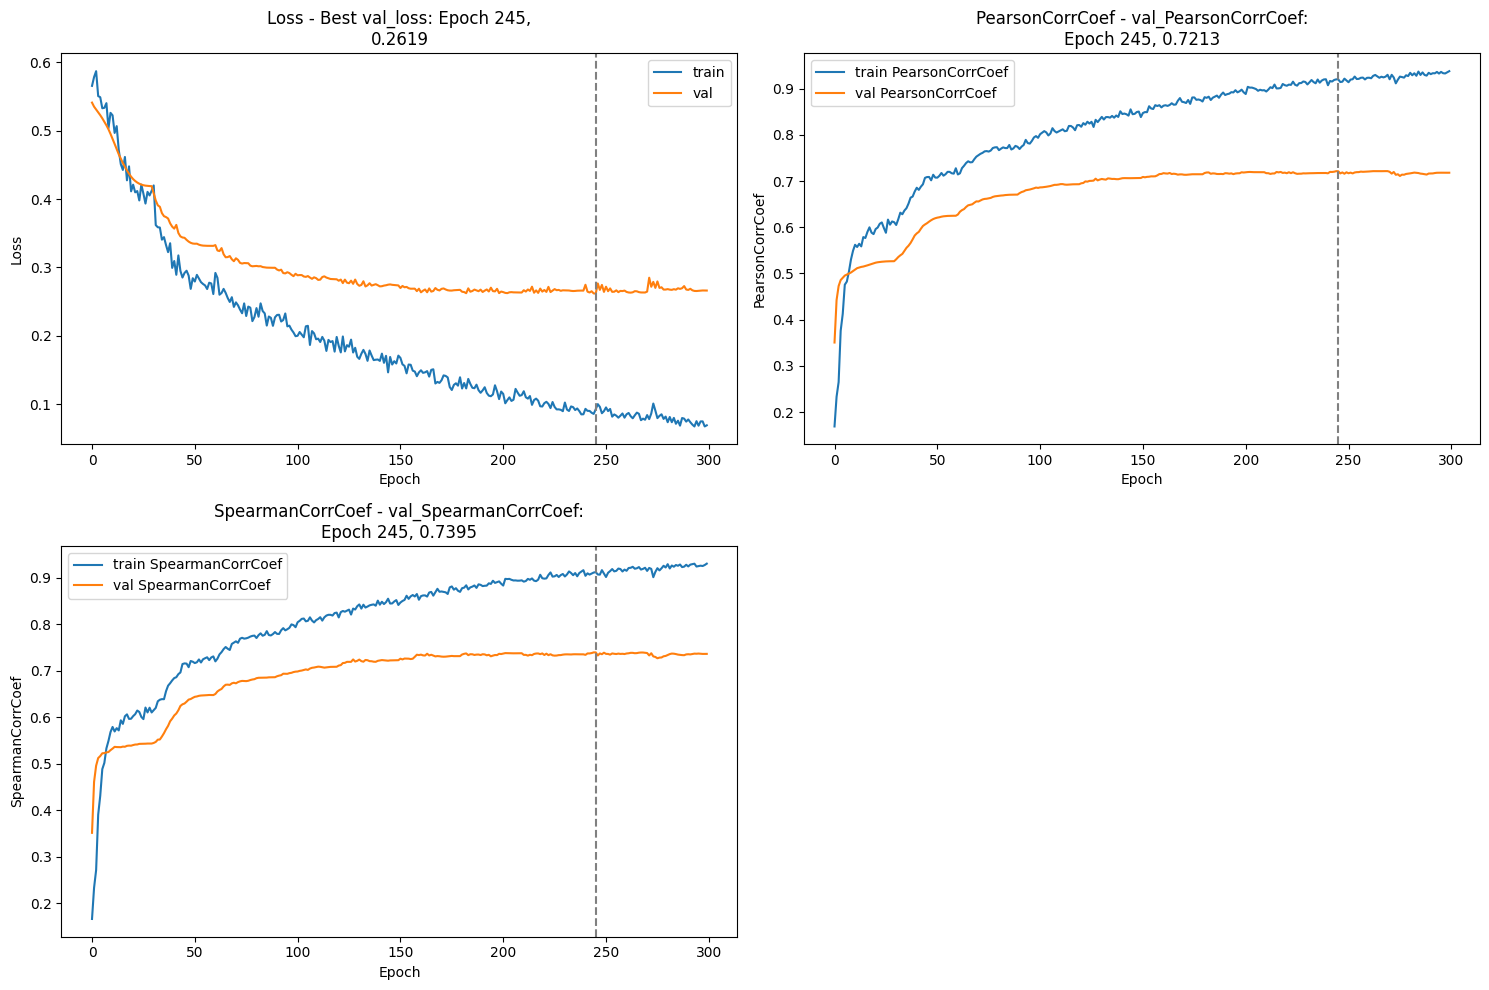

In [ ]:
# Calculate number of metrics plus loss
n_metrics = len(train_metrics.keys()) + 1  # +1 for loss plot
n_cols = 2  # You can adjust this
n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot losses
axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
val_loss_best_epoch = np.argmin(val_losses)
axes[0].set_title(f'Loss - Best val_loss: Epoch {val_loss_best_epoch},\n{val_losses[val_loss_best_epoch]:.4f}')
axes[0].axvline(val_loss_best_epoch, c='gray', ls='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot metrics
for idx, metric_name in enumerate(train_metrics.keys(), 1):
    train_metric_values = [x.item() if torch.is_tensor(x) else x for x in train_metrics[metric_name]]
    val_metric_values = [x.item() if torch.is_tensor(x) else x for x in val_metrics[metric_name]]

    axes[idx].plot(train_metric_values, label=f'train {metric_name}')
    axes[idx].plot(val_metric_values, label=f'val {metric_name}')
    axes[idx].axvline(val_loss_best_epoch, c='gray', ls='--')

    best_value = val_metric_values[val_loss_best_epoch]

    axes[idx].set_title(f'{metric_name} - val_{metric_name}:\nEpoch {val_loss_best_epoch}, {best_value:.4f}')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(metric_name)
    axes[idx].legend()

# Remove empty subplots if any
for idx in range(len(train_metrics.keys()) + 1, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# **5. visualize the predicted distributions by class at the best performing epoch**

Epoch 245: val PearsonCorrCoef: 0.721
Epoch 245: val SpearmanCorrCoef: 0.740


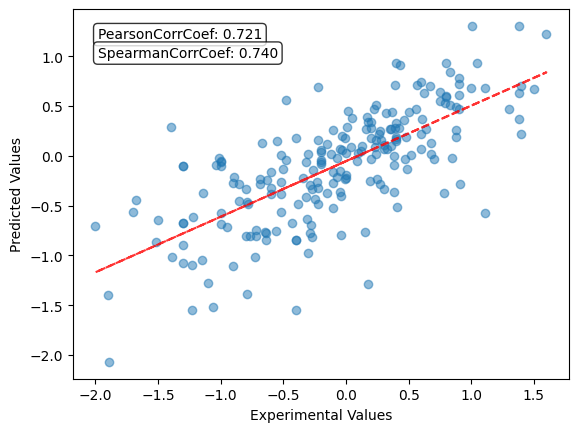

In [ ]:
# Find best epoch based on validation metrics
val_best_epoch = np.argmin(val_losses)  # or use appropriate metric

# Print best metrics for each metric type
for metric_name in val_metrics.keys():
    best_value = val_metrics[metric_name][val_best_epoch]
    print(f"Epoch {val_best_epoch}: val {metric_name}: {best_value:.3f}")

# Convert to numpy for plotting
L = np.array(epoch_val_labels[val_best_epoch])
P = np.array(epoch_val_predictions[val_best_epoch])

if task == 'classification':
    # Create a figure with 1x3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Box plot
    ax1.boxplot([P[L.flatten() == 0].flatten(), P[L.flatten() == 1].flatten()],
              labels=['Negative (0)', 'Positive (1)'])
    ax1.set_ylabel('Predicted Probabilities')
    ax1.set_ylim(0, 1)

    precision_val = val_metrics['BinaryPrecision'][val_best_epoch]
    recall_val = val_metrics['BinaryRecall'][val_best_epoch]

    ax1.text(0.05, 0.95,
           f'Precision: {precision_val:.3f}\nRecall: {recall_val:.3f}',
           transform=ax1.transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax1.set_title('Prediction Distribution')
    ax1.grid(True, alpha=0.3)

    # 2. Confusion Matrix
    P_binary = (P > 0.5).astype(int)
    cm = confusion_matrix(L, P_binary)

    im = ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix')
    plt.colorbar(im, ax=ax2)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax2.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax2.set_xticks([0, 1])
    ax2.set_yticks([0, 1])
    ax2.set_xticklabels(['Negative', 'Positive'])
    ax2.set_yticklabels(['Negative', 'Positive'])
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(L, P)
    roc_auc = auc(fpr, tpr)

    ax3.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Receiver Operating Characteristic')
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\nMetrics Summary:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC-ROC: {roc_auc:.3f}")

else:
    # Scatter plot for regression
    plt.scatter(L, P, alpha=0.5)

    # Calculate and plot regression line
    z = np.polyfit(L.flatten(), P.flatten(), 1)
    p = np.poly1d(z)
    plt.plot(L, p(L), "r--", alpha=0.8)

    # Add correlation coefficient
    for metric_name, values in val_metrics.items():
        best_value = values[val_best_epoch]
        plt.text(0.05, 0.95 - 0.05 * list(val_metrics.keys()).index(metric_name),
                f'{metric_name}: {best_value:.3f}',
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.ylabel('Predicted Values')
    plt.xlabel('Experimental Values')

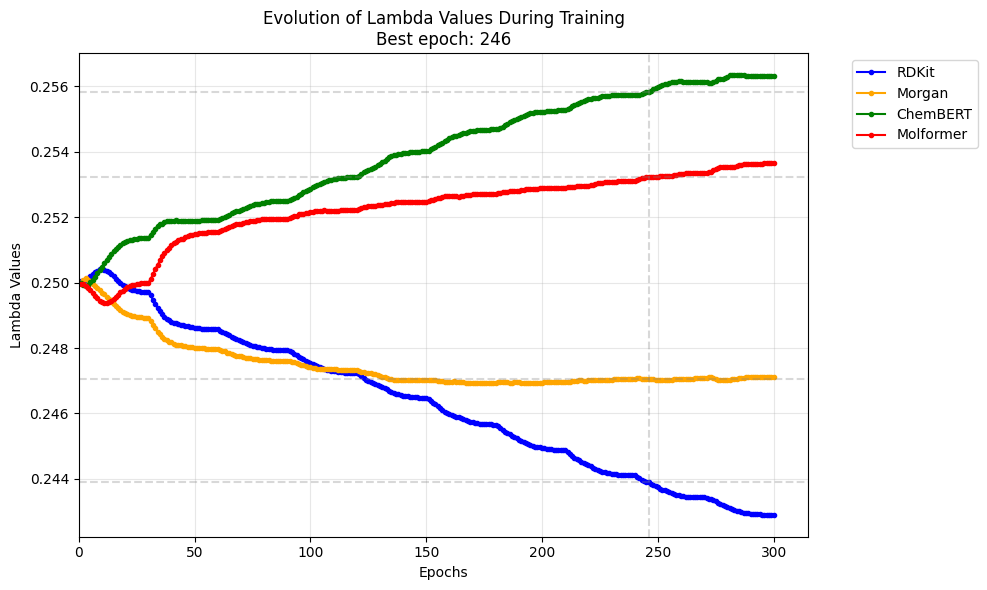


Lambda values at best epoch:
RDKit: 0.244
Morgan: 0.247
ChemBERT: 0.256
Molformer: 0.253


In [ ]:
# Convert list of lambdas to numpy array for easier plotting
lambdas_array = np.array(train_lambdas)  # shape: [n_epochs, 4, 1]
lambdas_array = lambdas_array.squeeze()  # shape: [n_epochs, 4]

# Create figure
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_lambdas) + 1)

# Define colors and labels
colors = ['b', 'orange', 'g', 'r', 'gray']
labels = ['RDKit', 'Morgan', 'ChemBERT', 'Molformer']

# Plot lambda evolution
for i in range(4):
    plt.plot(epochs, lambdas_array[:, i],
             label=labels[i],
             marker='.',
             c=colors[i])

# Add horizontal lines at best epoch values
for i in range(4):
    plt.axhline(y=lambdas_array[val_best_epoch, i],
                ls='--',
                c=colors[-1],
                alpha=0.3)

# Add vertical line at best epoch
plt.axvline(x=val_best_epoch+1,
            ls='--',
            c=colors[-1],
            alpha=0.3)

# Format lambda values for title
lambda_values = [f"{v:.3f}" for v in lambdas_array[val_best_epoch]]
lambda_text = ", ".join(lambda_values)

# Customize plot
plt.xlabel('Epochs')
plt.ylabel('Lambda Values')
plt.title(f'Evolution of Lambda Values During Training\n'
          f'Best epoch: {val_best_epoch+1}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0)
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Optional: Print lambda values at best epoch
print("\nLambda values at best epoch:")
for label, value in zip(labels, lambdas_array[val_best_epoch]):
    print(f"{label}: {value:.3f}")